# DIP Project: Iris Segmentation and Colour Classification

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0}) # remove warning about max figs open

import seaborn as sns

from skimage import io, color
from skimage.feature import canny
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle
from skimage import filters
from skimage.morphology import  convex_hull_image, black_tophat, dilation
from skimage.util import invert
from skimage.exposure import equalize_hist, equalize_adapthist

from scipy.stats import norm

## UPOL IRIS Database

The database contains 3 x 128 iris images (i.e. 3 x 64 left and 3 x 64 right).
The images are: 24 bit - RGB, 576 x 768 pixels, file format: PNG.
The irises were scanned by TOPCON TRC50IA optical device connected with SONY DXC-950P 3CCD camera.

- [Dataset Link](http://phoenix.inf.upol.cz/iris/)

The full dataset which was too big to be uploaded to Sakai can be found here:

- [Full Dataset](https://drive.google.com/file/d/1FCN_lG1UDJYNU3d3GnjChodc9CVxVD30/view?usp=sharing)

In [2]:
upol_images = io.ImageCollection('../data/UPOL/*')

# Procedure for Single Image
-----------------------------------

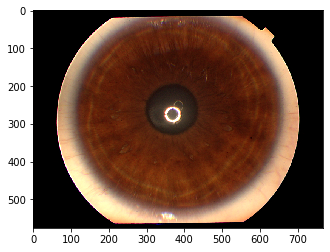

In [3]:
originalImage = upol_images[1]
plt.imshow(originalImage)

# Apply adaptive histogram equalization

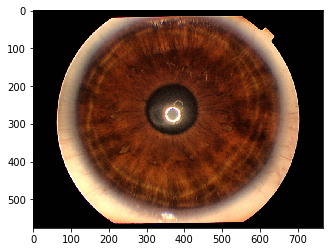

In [4]:
eq = equalize_adapthist(originalImage)
plt.imshow(eq)

### HSV Colorspace

- [Why do we use the HSV colour space so often in vision and image processing?](https://dsp.stackexchange.com/questions/2687/why-do-we-use-the-hsv-colour-space-so-often-in-vision-and-image-processing)

In [5]:
hsvImage = color.rgb2hsv(eq)

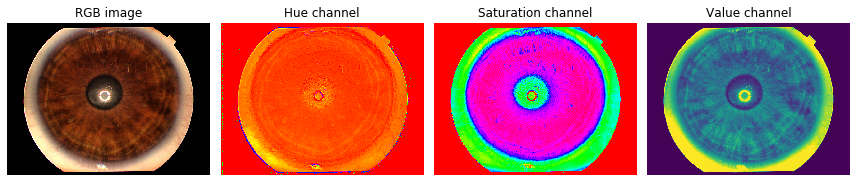

In [6]:
hueImage = hsvImage[:, :, 0]
satImage = hsvImage[:, :, 1]
valImage = hsvImage[:, :, 2]

fig, (ax0, ax1,ax2, ax3) = plt.subplots(ncols=4, figsize=(12, 5))

ax0.imshow(eq)
ax0.set_title("RGB image")
ax0.axis('off')

ax1.imshow(hueImage, cmap='hsv')
ax1.set_title("Hue channel")
ax1.axis('off')

ax2.imshow(satImage, cmap='hsv')
ax2.set_title("Saturation channel")
ax2.axis('off')

ax3.imshow(valImage)
ax3.set_title("Value channel")
ax3.axis('off')

fig.tight_layout()

### Median Filter for Denoising

The Median filter is a non-linear filter that is most commonly used as a simple way to reduce noise in an image. It's claim to fame (over Gaussian for noise reduction) is that it removes noise while keeping edges relatively sharp.

[Why is Gaussian filter used in image filtering? What are its advantages compared to other filters like median filter?](https://www.mathworks.com/matlabcentral/answers/294211-why-is-gaussian-filter-used-in-image-filtering-what-are-its-advantages-compared-to-other-filters-li#:~:text=A%20Gaussian%20filter%20is%20a,image%20or%20to%20reduce%20noise.&text=The%20Gaussian%20filter%20alone%20will,reduce%20noise%20in%20an%20image.)

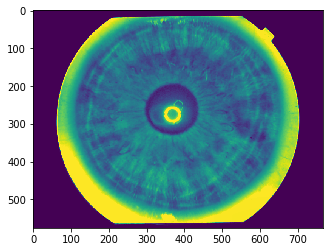

In [7]:
filtered_Image = filters.median(valImage, np.ones((3, 3)))
plt.imshow(filtered_Image)

### Threshold on Value Channel

Text(0.5, 1.0, 'Value between 2/8 and 6/8')

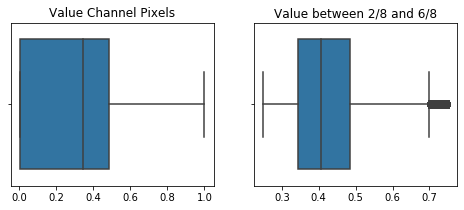

In [8]:
exclude_vals = (filtered_Image>2/8)&(filtered_Image<6/8)

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(8, 3))
sns.boxplot(filtered_Image.ravel(), ax=ax0)
ax0.set_title("Value Channel Pixels")
sns.boxplot(filtered_Image[exclude_vals].ravel(), ax=ax1)
ax1.set_title("Value between 2/8 and 6/8")

In [9]:
# Fit a normal distribution to the data:
mu, std = norm.fit(filtered_Image[exclude_vals].ravel())
# Replace mean with median
mu = np.median(filtered_Image[exclude_vals].ravel())

In [10]:
# Set threshold to be  2 std from the mean
min_val_threshold = mu-1.2*std
max_val_threshold = mu+1.2*std

![](https://upload.wikimedia.org/wikipedia/commons/thumb/8/8c/Standard_deviation_diagram.svg/220px-Standard_deviation_diagram.svg.png)

As can be seen from the graph above 95.4% of the pixel values fall within 2 standard deviations from the mean.

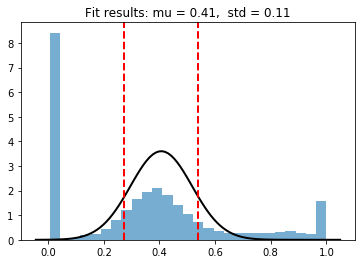

In [11]:
# Plot the data
plt.hist(filtered_Image.ravel(), bins =27, alpha=0.6, density=True)

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.axvline(x=min_val_threshold, color='r', linestyle='dashed', linewidth=2)
plt.axvline(x=max_val_threshold, color='r', linestyle='dashed', linewidth=2)
plt.title(title)

plt.show()


In [12]:
print(min_val_threshold, max_val_threshold)

0.2734648940783184 0.5392339069982659


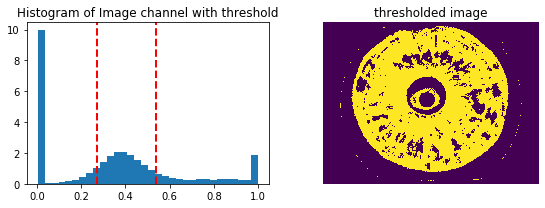

In [13]:

binary_img = (filtered_Image > min_val_threshold)&  (filtered_Image < max_val_threshold)

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(8, 3))

ax0.hist(filtered_Image.ravel(), bins =32, density=True)
ax0.set_title("Histogram of Image channel with threshold")
ax0.axvline(x=min_val_threshold, color='r', linestyle='dashed', linewidth=2)
ax0.axvline(x=max_val_threshold, color='r', linestyle='dashed', linewidth=2)
ax1.imshow(binary_img)
ax1.set_title("thresholded image")
ax1.axis('off')

fig.tight_layout()

### Hough Circle Iris Mask

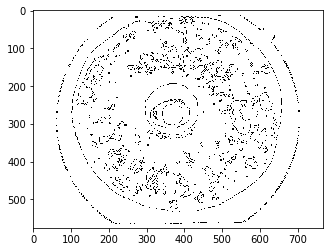

In [14]:
iris_edges = canny(binary_img, sigma=1, low_threshold=None, high_threshold=None)
plt.imshow(iris_edges, cmap='gray_r')

# Dilated to thicken edges

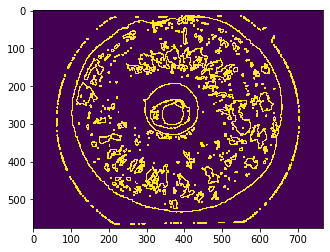

In [15]:
dil = dilation(iris_edges, np.ones((3, 3)))
plt.imshow(dil)

In [16]:
def get_houghcircle(edges, rad_low, rad_high):
    # Detect two radii
    hough_radii = np.arange(rad_low, rad_high, 10)
    hough_res = hough_circle(edges, hough_radii)

    # Select the most prominent 1 circle
    accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                               total_num_peaks=1)
    
    # Draw them
    circledImageMask = np.zeros_like(edges)
    for center_y, center_x, radius in zip(cy, cx, radii):
        circy, circx = circle(center_y, center_x, radius=radius, shape=circledImageMask.shape)
        circledImageMask[circy, circx] = 1
    return(circledImageMask, cx[0], cy[0], radii[0])

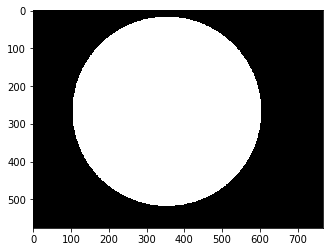

In [17]:
circledIrisMask, irisX, irisY, irisR = get_houghcircle(dil, 250, 300)
plt.imshow(circledIrisMask, cmap=plt.cm.gray)

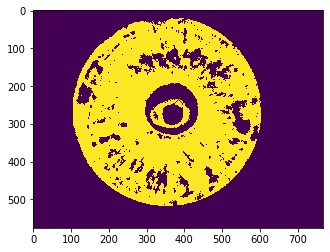

In [18]:
# Element-wise multiplication will apply the mask to the image
masked_Iris =  binary_img*circledIrisMask
plt.imshow(masked_Iris)

# Dilate and Blur to close holes

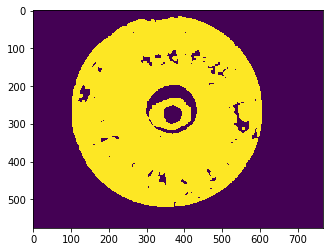

In [19]:
masked_Iris_dil = dilation(masked_Iris, np.ones((7, 7)))
plt.imshow(masked_Iris_dil)

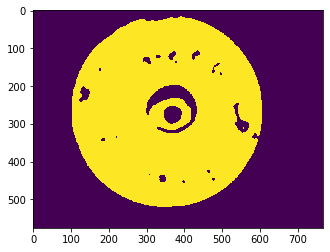

In [20]:
filtered_thresholdImage = filters.median(masked_Iris_dil, np.ones((11, 11)))
plt.imshow(filtered_thresholdImage)

### Hough Circle Pupil Mask

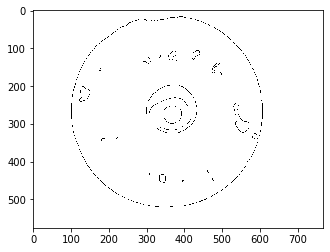

In [21]:
pupil_edges = canny(filtered_thresholdImage, sigma=1, low_threshold=None, high_threshold=None)
plt.imshow(pupil_edges, cmap='gray_r')

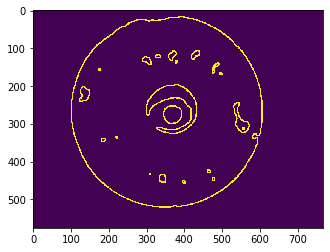

In [22]:
dil = dilation(pupil_edges, np.ones((3, 3)))
plt.imshow(dil)

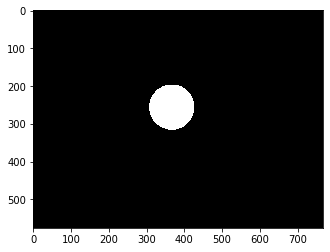

In [23]:
circledPupilMask, pupilX, pupilY, pupilR = get_houghcircle(pupil_edges, 40, 150)
plt.imshow(circledPupilMask, cmap=plt.cm.gray)

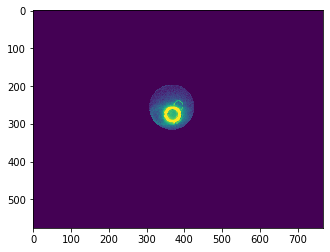

In [24]:
# Element-wise multiplication will apply the mask to the image
masked_Pupil =  valImage*circledPupilMask
plt.imshow(masked_Pupil)

### Create Segmentation Mask

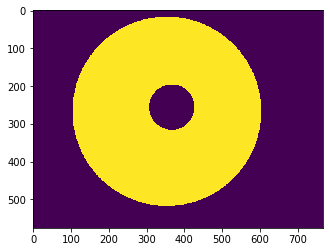

In [25]:
segmentationMask = np.bitwise_xor(circledIrisMask,circledPupilMask)
plt.imshow(segmentationMask)

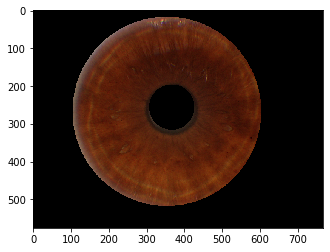

In [26]:
segmentedImage = originalImage.copy()
segmentedImage[np.invert(segmentationMask),:]=0
plt.imshow(segmentedImage)

# Polar transform to unwrap iris

In [27]:
def unwrap(img, irisR, pupilR, pupilX, pupilY):
    centre = (pupilX, pupilY)
    nsamples = 360
    samples = np.linspace(0, 2*np.pi, nsamples)[:-1]
    polar = np.zeros((irisR-pupilR, nsamples, 3), np.uint8)
    for r in range(pupilR, irisR):
        for theta in samples:
            x = int(r*np.cos(theta) + centre[0])
            y = int(r*np.sin(theta) + centre[1])
            if x >= 576 or y >= 576:
                polar[r-pupilR][int(theta*nsamples / 2.0 / np.pi)] = np.array([0, 0, 0])
            else:
                polar[r-pupilR][int(theta*nsamples / 2.0 / np.pi)] = img[y][x]
    return polar

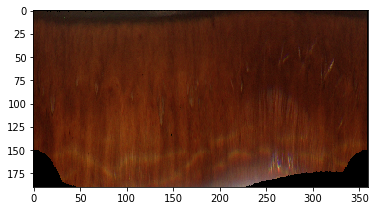

In [28]:
polar = unwrap(segmentedImage, irisR, pupilR, pupilX, pupilY)
plt.imshow(polar)

### Get Eye Color

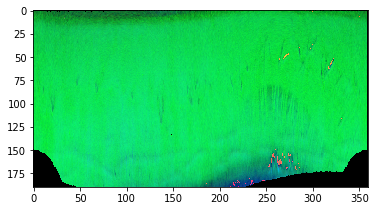

In [29]:
hsvWrap = color.rgb2hsv(polar)
plt.imshow(hsvWrap)

In [30]:
def scaleIntensity(f, K):
    fm = f - np.min(f)
    fs = K*(fm/np.max(fm))
    return fs

In [31]:
def scaleHsv(hsvWrap):
    hsvWrap[:, :, 0] = scaleIntensity(hsvWrap[:, :, 0], 360)
    hsvWrap[:, :, 1] = scaleIntensity(hsvWrap[:, :, 1], 255)
    hsvWrap[:, :, 2] = scaleIntensity(hsvWrap[:, :, 2], 255)
    return hsvWrap

In [32]:
hsvWrap_scaled = scaleHsv(hsvWrap)

In [33]:
def check_color(hsv, color):
    if (hsv[0] >= color[0][0]) and (hsv[0] <= color[1][0]) and (hsv[1] >= color[0][1]) and \
    hsv[1] <= color[1][1] and (hsv[2] >= color[0][2]) and (hsv[2] <= color[1][2]):
        return True
    else:
        return False

In [34]:
def is_EyeColor(mean_hsv):
    defined_colors = ['Brown', 'Hazel', 'Blue', 'Green', 'Gray', 'Amber', 'Other']
    defined_color_range = {
        "Brown" : ((0, 170, 50), (50, 250, 100)),
        "Hazel" : ((0, 150, 70), (50, 200, 150)),
        "Blue": ((150, 50, 100), (250, 150, 200)),
        "Green" : ((50, 150, 50), (120, 250, 150)),
        "Gray" : ((0, 0, 100), (230, 50, 150)),
        "Amber" : ((0, 200, 100), (60, 250, 150)),
    }
    color_id = 6
    for i in range(len(defined_colors)-1):
        if check_color(mean_hsv, defined_color_range[defined_colors[i]]) == True:
            color_id = i
    return color_id

In [35]:
def find_eye_color(mean_hsv):
    eye_class = np.zeros(7, np.float)
    defined_colors = ['Brown', 'Hazel', 'Blue', 'Green', 'Gray', 'Amber', 'Other']
    for y in range(mean_hsv.shape[0]):
        for x in range(mean_hsv.shape[1]):
            if mean_hsv[y, x, 0] != 0 and mean_hsv[y, x, 1] != 0 and mean_hsv[y, x, 2] != 0:
                val = is_EyeColor(mean_hsv[y,x])
                eye_class[val] += 1
    colorIndex = np.argmax(eye_class)
    colorPred = defined_colors[colorIndex]
    if colorPred == 'Other':
        eye_c = eye_class[:-1]
        colorIndex = np.argmax(eye_c)
        colorPred = defined_colors[colorIndex]
    return eye_class, colorPred

In [36]:
find_eye_color(hsvWrap)

(array([2.5395e+04, 5.4570e+03, 0.0000e+00, 1.0000e+00, 8.0000e+00,
        2.9447e+04, 4.6550e+03]),
 'Amber')

# Procedure for Multiple Images
---------------------------------

In [ ]:
ch = 2 # set the channel

In [ ]:
for i, image in enumerate(upol_images):
    if i%6==0: # 6 images per person we only want one person
        eq = equalize_adapthist(image)
        # HSV Conversion
        hsv = color.rgb2hsv(eq) 

        # Get image Channel
        img_ch = hsv[:, :, 2]

        # Denoising using median filter
        filtered_Image = filters.median(img_ch, np.ones((3, 3))) 

        # Set extreme values to exclude
        exclude_vals = (filtered_Image>2/8)&(filtered_Image<6/8)
        # Fit a normal distribution to the data excluding extreme values
        mu, std = norm.fit(filtered_Image[exclude_vals].ravel())
        # Replace mean with median
        mu = np.median(filtered_Image[exclude_vals].ravel())

        # Set threshold to be 2 std from the median
        min_val_threshold = mu-1.2*std
        max_val_threshold = mu+1.2*std

        # Apply Thresholding
        binary_img = (filtered_Image > min_val_threshold)&  (filtered_Image < max_val_threshold)

        # Get Iris 
        iris_edges = canny(binary_img, sigma=1, low_threshold=None, high_threshold=None)
        dil = dilation(iris_edges, np.ones((3, 3)))
        circledIrisMask, irisX, irisY, irisR = get_houghcircle(dil,250,300)
        masked_Iris =  binary_img*circledIrisMask
        masked_Iris_dil = dilation(masked_Iris, np.ones((7, 7)))
        filtered_thresholdImage = filters.median(masked_Iris_dil, np.ones((11, 11)))

        # Get Pupil
        pupil_edges = canny(filtered_thresholdImage, sigma=1, low_threshold=None, high_threshold=None)
        dil = dilation(pupil_edges, np.ones((3, 3)))
        circledPupilMask, pupilX, pupilY, pupilR  = get_houghcircle(dil, 50, 150)
        masked_Pupil =  img_ch*circledPupilMask

        # Generate Segmentation Mask
        segmentationMask = np.bitwise_xor(circledIrisMask,circledPupilMask)
        segmentedImage = image.copy()
        segmentedImage[np.invert(segmentationMask),:] = 0

        polar = unwrap(segmentedImage, irisR, pupilR, pupilX, pupilY)

        hsvWrap = color.rgb2hsv(polar)

        hsvWrap = scaleHsv(hsvWrap)

        percentages, prediction = find_eye_color(hsvWrap)

        # Graphs
        fig, axs = plt.subplots(ncols=9, figsize=(30, 10))

        axs[0].imshow(image)
        axs[0].set_title(i)
        axs[0].axis('off')

        axs[1].imshow(img_ch)
        axs[1].set_title("Value Ch.")
        axs[1].axis('off')

        axs[2].imshow(binary_img)
        axs[2].set_title("Threshold Image")
        axs[2].axis('off')

        axs[3].imshow(circledIrisMask, cmap ="gray")
        axs[3].set_title("Iris Circle")
        axs[3].axis('off')


        axs[4].imshow(circledPupilMask, cmap='gray')
        axs[4].set_title("Pupil Circle")
        axs[4].axis('off')

        axs[5].imshow(segmentationMask)
        axs[5].set_title("Final Mask")
        axs[5].axis('off')

        axs[6].imshow(segmentedImage)
        axs[6].set_title("Iris Image")
        axs[6].axis('off')

        axs[7].imshow(polar)
        axs[7].set_title("Unwrapped Iris")
        axs[7].axis('off')


        axs[8].text(0.5,0.5,prediction, ha='center', va='center', size=32)
        axs[8].set_title("Predicted Colour")
        axs[8].axis('off')
        asp9 = np.diff(axs[8].get_xlim())[0] / np.diff(axs[8].get_ylim())[0]
        axs[8].set_aspect(asp9)

        plt.subplots_adjust(wspace = 0.01, hspace = 0)

In [ ]:
data_images = io.ImageCollection('../data/Images/*')

In [ ]:
plt.imshow(data_images[0])

In [ ]:
for i, image in enumerate(data_images):
    eq = equalize_adapthist(image)
    # HSV Conversion
    hsv = color.rgb2hsv(eq) 

    # Get image Channel
    img_ch = hsv[:, :, 2]

   # Denoising using median filter
    filtered_Image = filters.median(img_ch, np.ones((3, 3))) 

    # Set extreme values to exclude
    exclude_vals = (filtered_Image>2/8)&(filtered_Image<6/8)
    # Fit a normal distribution to the data excluding extreme values
    mu, std = norm.fit(filtered_Image[exclude_vals].ravel())
    # Replace mean with median
    mu = np.median(filtered_Image[exclude_vals].ravel())

    # Set threshold to be 2 std from the median
    min_val_threshold = mu-1.2*std
    max_val_threshold = mu+1.2*std

    # Apply Thresholding
    binary_img = (filtered_Image > min_val_threshold)&  (filtered_Image < max_val_threshold)

    # Get Iris 
    iris_edges = canny(binary_img, sigma=1, low_threshold=None, high_threshold=None)
    dil = dilation(iris_edges, np.ones((3, 3)))
    circledIrisMask, irisX, irisY, irisR = get_houghcircle(dil,250,300)
    masked_Iris =  binary_img*circledIrisMask
    masked_Iris_dil = dilation(masked_Iris, np.ones((19, 19)))
    filtered_thresholdImage = filters.median(masked_Iris_dil, np.ones((21, 21)))

    # Get Pupil
    pupil_edges = canny(filtered_thresholdImage, sigma=1, low_threshold=None, high_threshold=None)
    dil = dilation(pupil_edges, np.ones((3, 3)))
    circledPupilMask, pupilX, pupilY, pupilR  = get_houghcircle(dil, 50, 150)
    masked_Pupil =  img_ch*circledPupilMask

    # Generate Segmentation Mask
    segmentationMask = np.bitwise_xor(circledIrisMask,circledPupilMask)
    segmentedImage = image.copy()
    segmentedImage[np.invert(segmentationMask),:] = 0

    polar = unwrap(segmentedImage, irisR, pupilR, pupilX, pupilY)

    hsvWrap = color.rgb2hsv(polar)

    hsvWrap = scaleHsv(hsvWrap)
    
    percentages, prediction = find_eye_color(hsvWrap)

    # Graphs
    fig, axs = plt.subplots(ncols=9, figsize=(30, 10))

    axs[0].imshow(image)
    axs[0].set_title(i)
    axs[0].axis('off')

    axs[1].imshow(img_ch)
    axs[1].set_title("Value Ch.")
    axs[1].axis('off')

    axs[2].imshow(binary_img)
    axs[2].set_title("Threshold Image")
    axs[2].axis('off')

    axs[3].imshow(circledIrisMask, cmap ="gray")
    axs[3].set_title("Iris Circle")
    axs[3].axis('off')


    axs[4].imshow(circledPupilMask, cmap='gray')
    axs[4].set_title("Pupil Circle")
    axs[4].axis('off')

    axs[5].imshow(segmentationMask)
    axs[5].set_title("Final Mask")
    axs[5].axis('off')

    axs[6].imshow(segmentedImage)
    axs[6].set_title("Iris Image")
    axs[6].axis('off')
    
    axs[7].imshow(polar)
    axs[7].set_title("Unwrapped Iris")
    axs[7].axis('off')


    axs[8].text(0.5,0.5,prediction, ha='center', va='center', size=32)
    axs[8].set_title("Predicted Colour")
    axs[8].axis('off')
    asp9 = np.diff(axs[8].get_xlim())[0] / np.diff(axs[8].get_ylim())[0]
    axs[8].set_aspect(asp9)
    
    plt.subplots_adjust(wspace = 0.01, hspace = 0)